# Quantum pipeline using the Quantum Trainer

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [ ]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

### Create diagrams

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove the cups

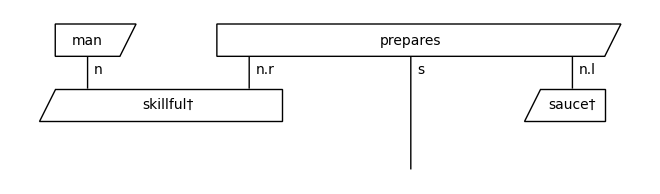

In [5]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

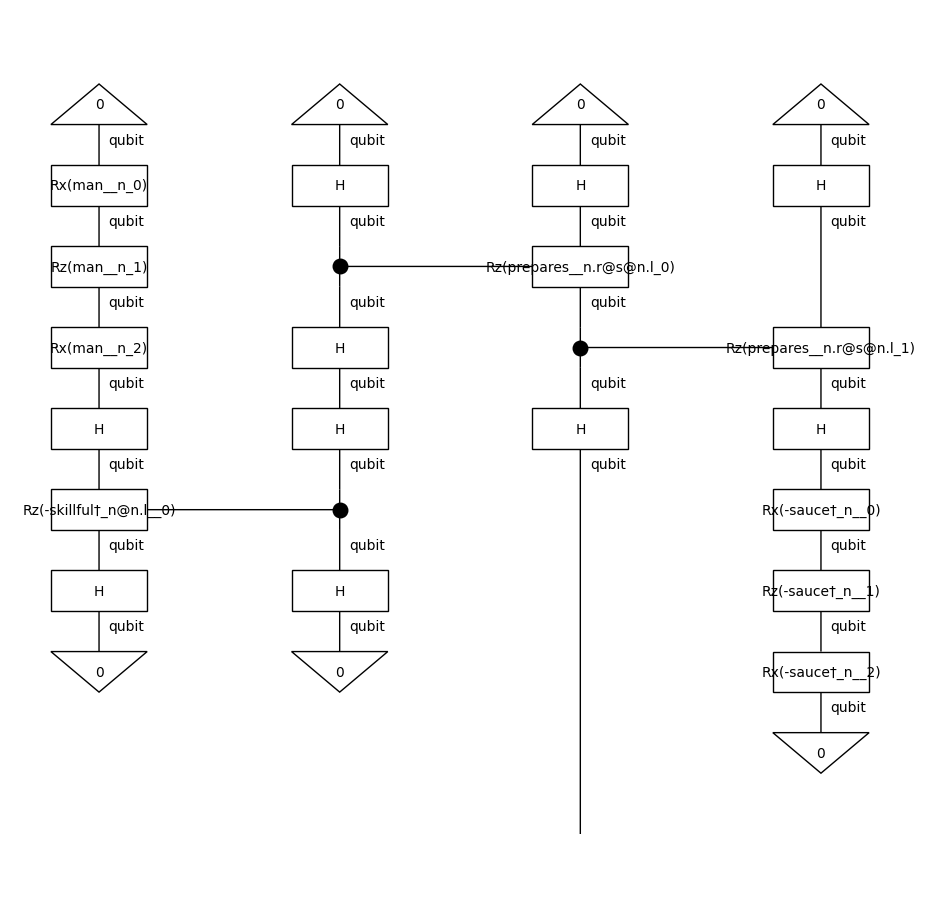

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 9))

### Parameterise

In [7]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

### Define evaluation metric

In [8]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [9]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [11]:
trainer.fit(train_dataset, val_dataset, log_interval=12)

Epoch 12:   train/loss: 0.9933   valid/loss: 0.7250   train/time: 2m12s   valid/time: 28.60s   train/acc: 0.4143   valid/acc: 0.6667
Epoch 24:   train/loss: 0.5887   valid/loss: 0.7874   train/time: 2m12s   valid/time: 28.67s   train/acc: 0.5214   valid/acc: 0.6333
Epoch 36:   train/loss: 0.4722   valid/loss: 0.6482   train/time: 2m12s   valid/time: 28.88s   train/acc: 0.5000   valid/acc: 0.5667
Epoch 48:   train/loss: 0.7078   valid/loss: 0.6945   train/time: 2m13s   valid/time: 29.54s   train/acc: 0.5857   valid/acc: 0.5667
Epoch 60:   train/loss: 0.6420   valid/loss: 0.6984   train/time: 2m13s   valid/time: 29.42s   train/acc: 0.6857   valid/acc: 0.5667
Epoch 72:   train/loss: 0.4834   valid/loss: 0.6600   train/time: 2m13s   valid/time: 28.98s   train/acc: 0.7214   valid/acc: 0.6333
Epoch 84:   train/loss: 0.4401   valid/loss: 0.6201   train/time: 2m14s   valid/time: 28.66s   train/acc: 0.6857   valid/acc: 0.6167
Epoch 96:   train/loss: 0.6992   valid/loss: 0.6210   train/time: 2m1

### Show results

Test accuracy: 0.7333333333333333


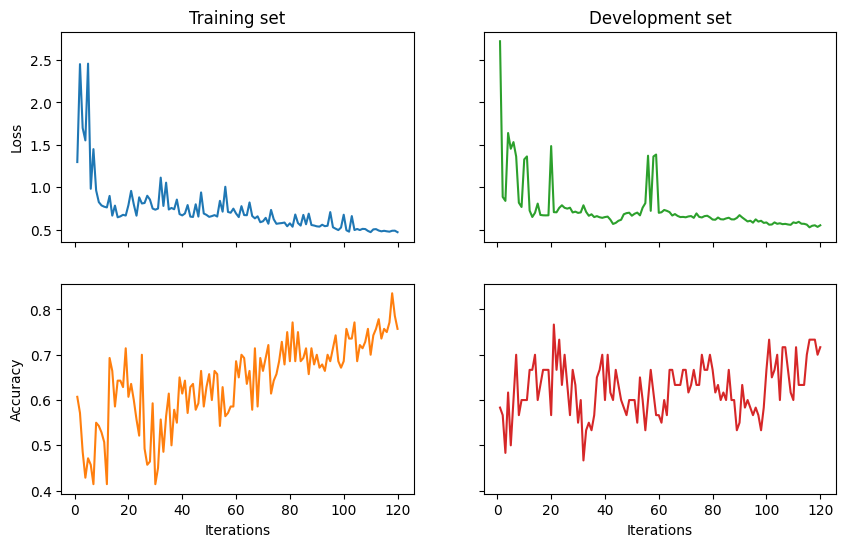

In [12]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)